<a href="https://colab.research.google.com/github/PhoenixCC0722/Journey_to_become_DataScientist/blob/main/Chapter7_supervised_ML_06_classification__ordinal_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinal Encoding with Titanic

In this notebook, we implement ordinal encoding to the column "Cabin" in the Titanic dataset. The column has been initially "engineered" so that only the first letter remains. Then, the order of the categories is manually defined, alphabetically, from "A" to "T", and ultimatelly with "N_A" (the replacement for null values).

With this choice of preprocessing, we achieve a more compact dataset (fewer columns created with one-hot encoding), although our pipeline gets more complex: the categorical branch will contain now the SimpleImputer, followed by a ColumnTransformer that branches into One Hot and Ordinal encoding.

A common error is trying to use a ColumnTransformer after the column names have been lost in a previous pipeline step (in our case, the SimpleImputer). This can be solved either using a pandas method instead of a sklearn transformer (e.g. `df.fill_na`), wrapped in a FunctionTransformer, as we will demonstrate in the sample solution for the Housing dataset, or by passing the indeces instead of the column names to the ColumnTransformer, as we show here.

## 1. Reading, cleaning & splitting

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import set_config

# reading
url = "https://drive.google.com/file/d/1g3uhw_y3tboRm2eYDPfUzXXsw8IOYDCy/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

# X and y creation
X = data.drop(columns=["PassengerId", "Name", "Ticket"])
y = X.pop("Survived")

# Feature Engineering
X.loc[:, "Cabin"] = X.Cabin.str[0]
'''
The column has been initially "engineered" so that only the first letter remains.
Then, the order of the categories is manually defined, alphabetically, from "A" to "T",
and ultimatelly with "N_A" (the replacement for null values).
'''
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 2. Building the `preprocessor`

We have included all the code to create the preprocessing pipeline in a single cell for compactness. Take your time to understand what's going on. If needed, create multiple cells and bring the code there step by step, analyzing the output each time. Writing a sketch of the pipeline with pen an paper is also a good idea.

In [4]:
# 0. Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

# 1. defining categorical & numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

# 3. categorical pipeline

# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names
ordinal_cols = ["Cabin"]
onehot_cols = ["Sex", "Embarked"]

# # 3.2. defining the categorical encoder

# # # 3.2.1. we manually establish the order of the categories for our ordinal feature (Cabin), including "N_A"
cabin_cats = ["N_A", "T", "G", "F", "E", "D", "C", "B", "A"]


# # # 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=[cabin_cats]), ordinal_cols),
        ("cat_onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
    ]
)

# # 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="N_A"),
                                 categorical_encoder
                                )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                ('cat_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('columntransformer',
                                                  ColumnTransformer(transformers=[('cat_ordinal',
                                                                                   OrdinalEncoder(categories=[['N_A',
                                                                                                               'T',
                                                                                                               'G',
                                                                                                               'F',
                                                                                                               'E',
                                                                                                               'D',
                                                                                                               'C',
                                                                                                               'B',
                                                                                                               'A']]),
                                                                                   ['Cabin']),
                                                                                  ('cat_onehot',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['Sex',
                                                                                    'Embarked'])]))]),
                                 Index(['Sex', 'Cabin', 'Embarked'], dtype='object'))])

## 3. Decision Tree

In [5]:
from sklearn.model_selection import GridSearchCV

# full pipeline: preprocessor + model
full_pipeline = make_pipeline(full_preprocessing,
                              DecisionTreeClassifier())

# define parameter grid
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

scores = {"dtree" : search.best_score_}

scores

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'dtree': 0.8033586132177681}

## 4. Error analysis

In [6]:
accuracy_score(search.predict(X_test), y_test)

0.8435754189944135

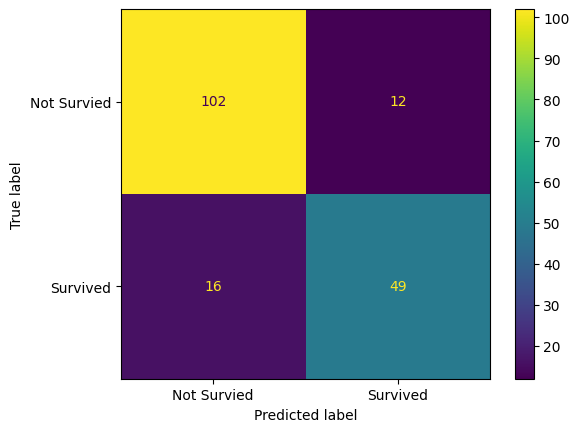

In [7]:
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(search, X_test, y_test, display_labels=['Not Survied', 'Survived']);

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(search,
                                      X_test,
                                      y_test,
                                      display_labels=['Not Survied', 'Survived']);

## 5. KNN (KNeighborsClassifier)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn_full_pipeline = make_pipeline(full_preprocessing,
                                  StandardScaler(),
                                  KNeighborsClassifier()
                                 )

In [9]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "kneighborsclassifier__n_neighbors": range(2, 50, 2),
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "standardscaler__with_std":[True, False]
}

knn_search = GridSearchCV(knn_full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

knn_search.fit(X_train, y_train)

scores["knn"] = knn_search.best_score_

scores

Fitting 5 folds for each of 192 candidates, totalling 960 fits


{'dtree': 0.8033586132177681, 'knn': 0.8188121737417511}

In [10]:
knn_search.best_params_

{'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
 'kneighborsclassifier__n_neighbors': 12,
 'kneighborsclassifier__weights': 'uniform',
 'standardscaler__with_std': True}

## **Your challenge**

In a new notebook, apply everything you have learned here to the Housing project, following the Learning platform.

### Step 1. Reading, cleaning & splitting

In [11]:
# reading -- 1st method
url = "https://drive.google.com/file/d/19Y4XiO3Ryd6kLDAmyBSf83DJCnLxIJcB/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = df = pd.read_csv(path)

'''
# reading -- 2nd method
# google sheet: https://docs.google.com/spreadsheets/d/1Bh45i6tsEflDaZiX1eFHqHJv-jak7WRSrT1PTdIDPcc/edit?gid=311092830#gid=311092830
sheet_id = "1Bh45i6tsEflDaZiX1eFHqHJv-jak7WRSrT1PTdIDPcc"
sheet_name = "311092830"

# Construct the URL to the CSV export of the spreadsheet
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Read the CSV data into a Pandas DataFrame
data = pd.read_csv(url)
'''
# X (feature vector) and y (Label/target) creation
# X = data.drop(columns=["PassengerId", "Name", "Ticket"])
X = data
y = X.pop("Expensive")

# Feature Engineering
X.loc[:, "Foundation"] = X.Foundation.str[0]
X.loc[:, "BsmtFinType1"] = X.BsmtFinType1.str[0]

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
X.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning',
       'Condition1', 'Heating', 'Street', 'CentralAir', 'Foundation',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      dtype='object')

In [13]:
X.CentralAir.unique()

array(['Y', 'N'], dtype=object)

In [14]:
X.ExterCond.unique()

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

In [17]:
X.Heating.unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

In [18]:
X.Street.unique()

array(['Pave', 'Grvl'], dtype=object)

In [19]:
len(X.columns)

23

**for all the no-number columns, to check the uniques values in each column and then decide which feature vector can apply the ordinal_encoding and which can apply the onehot_encoding.**

In [20]:
import pandas as pd

# Select only categorical columns (exclude numerical)
X_cat = X.select_dtypes(exclude="number").copy()

# Loop through the categorical columns
for column in X_cat.columns:
    unique_values = X_cat[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print("-" * 20)  # Separator for readability

Column: MSZoning
Unique Values: ['RL' 'RM' 'C (all)' 'FV' 'RH']
--------------------
Column: Condition1
Unique Values: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
--------------------
Column: Heating
Unique Values: ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
--------------------
Column: Street
Unique Values: ['Pave' 'Grvl']
--------------------
Column: CentralAir
Unique Values: ['Y' 'N']
--------------------
Column: Foundation
Unique Values: ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
--------------------
Column: ExterQual
Unique Values: ['Gd' 'TA' 'Ex' 'Fa']
--------------------
Column: ExterCond
Unique Values: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
--------------------
Column: BsmtQual
Unique Values: ['Gd' 'TA' 'Ex' nan 'Fa']
--------------------
Column: BsmtCond
Unique Values: ['TA' 'Gd' nan 'Fa' 'Po']
--------------------
Column: BsmtExposure
Unique Values: ['No' 'Gd' 'Mn' 'Av' nan]
--------------------
Column: BsmtFinType1
Unique Values: ['GLQ' 'ALQ' 'Unf' 'Rec'

### Step 2. Building the preprocessor

In [21]:
# 0. Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

# 1. defining categorical & numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

# 3. categorical pipeline
# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names
ordinal_cols = ["Foundation", "BsmtFinType1"]
onehot_cols = ["Street", "CentralAir"]